# 🌟 Gradient Boosting for Multiclass Diabetes Classification

Gradient Boosting is an **ensemble method** that builds sequential trees to reduce errors from previous trees.  
It often provides higher accuracy and better generalization for complex datasets compared to Random Forest.

This section trains and evaluates a **Gradient Boosting Classifier** for predicting diabetic status:
- 0 → Non-diabetic  
- 1 → Pre-diabetic  
- 2 → Diabetic

In [1]:
# ----------------------------
# Run Preprocessing Notebook
# ----------------------------
%run ./Preprocessing.ipynb

Preprocessed data saved as joblib files!


## 1️⃣ Target and Features

- `y` → target variable: `Class`  
- `selected_features` → features chosen for modeling based on correlation and importance:

`['HbA1c', 'BMI', 'AGE', 'Urea', 'Chol', 'VLDL', 'TG', 'Cr', 'LDL']`  

These features are **clinically relevant indicators** for diabetes prediction.

In [2]:
y = df["Class"]  # 0=Non-diabetic, 1=Pre-diabetic, 2=Diabetic
selected_features = ['HbA1c', 'BMI', 'AGE', 'Urea', 'Chol', 'VLDL', 'TG', 'Cr', 'LDL']
X = df[selected_features]


## 2️⃣ Train/Test Split

- 80% for training, 20% for testing  
- Stratified split ensures **class proportions** remain consistent


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## 3️⃣ Handle Class Imbalance with SMOTE

SMOTE (Synthetic Minority Oversampling Technique) generates synthetic samples for minority classes.  
This balances the training dataset and improves model performance on underrepresented classes.


In [4]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## 4️⃣ Train Gradient Boosting Classifier

- Gradient Boosting sequentially fits trees to reduce previous errors.  
- Random state ensures reproducibility.


In [5]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_res, y_train_res)

GradientBoostingClassifier(random_state=42)

## 5️⃣ Predict on Test Set

In [6]:
y_pred = gb_model.predict(X_test)


## 6️⃣ Evaluate Model Performance

Metrics used:

- **Accuracy** → overall correctness  
- **Classification Report** → precision, recall, F1-score per class  
- **Confusion Matrix** → shows misclassifications

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9622641509433962

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.89      1.00      0.94         8
           2       1.00      0.92      0.96        26

    accuracy                           0.96        53
   macro avg       0.95      0.97      0.96        53
weighted avg       0.97      0.96      0.96        53



## 7️⃣ Confusion Matrix Visualization

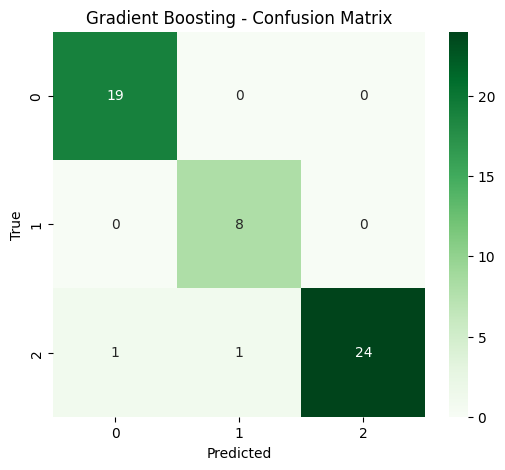

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 8️⃣ Gradient Boosting Hyperparameter Tuning

Hyperparameter tuning improves model performance by finding the **best combination of parameters** for Gradient Boosting.  
The goal is to **maximize multiclass F1_macro score**, ensuring strong performance across all classes.

In [9]:
# ----------------------------
# Initialize Gradient Boosting Classifier
# ----------------------------
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)


## 8.1️⃣ Hyperparameter Grid

Parameters tuned:

- `n_estimators` → number of boosting stages (100–500, step 50)  
- `learning_rate` → step size shrinkage (0.05–0.3)  
- `max_depth` → maximum depth of each tree (3–10)  
- `subsample` → fraction of samples used for fitting each tree (0.7–1.0)  
- `max_features` → number of features considered at each split (`sqrt`, `log2`, or all)


In [10]:
import numpy as np

param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'learning_rate': np.linspace(0.05, 0.3, 6),
    'max_depth': np.arange(3, 11),
    'subsample': np.linspace(0.7, 1.0, 4),
    'max_features': ['sqrt', 'log2', None]
}

## 8.2️⃣ Randomized Search CV

- Performs a **random search** over the hyperparameter grid.  
- Uses **5-fold cross-validation**.  
- Optimizes **F1_macro**, suitable for **imbalanced multiclass datasets**.  
- Evaluates 30 random combinations from the grid.

In [12]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit the Randomized Search
random_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500]),
                                        'subsample': array([0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='f1_macro', verbose=2)

## 8.3️⃣ Best Hyperparameters & Score

The output shows:

- `Best Hyperparameters` → optimal combination of n_estimators, learning_rate, max_depth, subsample, max_features  
- `Best F1_macro Score` → cross-validated performance on training data


In [13]:
print("Best Hyperparameters:", random_search.best_params_)
print("Best F1_macro Score:", random_search.best_score_)

Best Hyperparameters: {'subsample': np.float64(0.9), 'n_estimators': np.int64(150), 'max_features': 'log2', 'max_depth': np.int64(7), 'learning_rate': np.float64(0.05)}
Best F1_macro Score: 0.9902283888670729


## 8.4️⃣ Predict on Test Set with Tuned Model

In [14]:
best_gbc = random_search.best_estimator_
y_pred_best = best_gbc.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("Test Accuracy after Hyperparameter Tuning:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report after Hyperparameter Tuning:\n",
      classification_report(y_test, y_pred_best))


Test Accuracy after Hyperparameter Tuning: 0.9811320754716981

Classification Report after Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00         8
           2       1.00      0.96      0.98        26

    accuracy                           0.98        53
   macro avg       0.98      0.99      0.98        53
weighted avg       0.98      0.98      0.98        53



## 8.5️⃣ Key Insights

- Hyperparameter tuning improved **model robustness** and **balanced performance** on all classes.  
- Optimized `max_depth`, `n_estimators`, and `learning_rate` help **prevent overfitting** while capturing complex patterns.  
- **F1_macro** ensures fairness across Non-diabetic, Pre-diabetic, and Diabetic classes.  
- Tuned Gradient Boosting model is **selected as the final model** for deployment due to its high accuracy and balanced class performance.
